Imports

In [1]:
# Install slash import libraries if needed (only the first time)
# (You can comment out the pip installs after your first successful run.)

!pip install nltk spacy tqdm yfinance

import gzip
import json
import random
import re

import spacy
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from nltk.tokenize import word_tokenize, sent_tokenize



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


NLTK & spaCy Setup

In [4]:
!python -m spacy download en_core_web_sm

# Download NLTK’s punkt tokenizer (if you haven’t already)
nltk.download('punkt')

# Load the small English model in spaCy (disable unnecessary components)
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "lemmatizer"])


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 1.1 MB/s eta 0:00:12
     - -------------------------------------- 0.5/12.8 MB 1.1 MB/s eta 0:00:12
     -- ------------------------------------- 0.8/12.8 MB 1.0 MB/s eta 0:00:12
     ---- ----------------------------------- 1.3/12.8 MB 1.3 MB/s eta 0:00:09
     ----- ---------------------------------- 1.8/12.8 MB 1.5 MB/s eta 0:00:08
     ------ --------------------------------- 2.1/12.8 MB 1.5 MB/s eta 0:00:08
     -------- ------------------------------- 2.6/12.8 MB 1.6 MB/s eta 0:00:07
     --------- ------------------------------ 3.1/12.8 MB 1.7 MB/s eta 0:00:06
     ----------- ---------------------------- 3.7/12.8 MB 1.8 MB/s eta 0:00:06
     ------------- -------------------------- 4.2/12.8 MB 1.8 MB/s eta 0:


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\roee1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Set File Paths & Sampling Parameters

In [5]:
# 1) Path to the raw FNSPID file you placed under data/raw/
INPUT_PATH = "../data/raw/news_2020_2025.jsonl.gz"

# 2) Where to write our 10k‐article sample
OUTPUT_SAMPLE = "../data/sampled/10k_sample.jsonl"

# 3) Approximate total lines in news_2020_2025.jsonl.gz
TOTAL_LINES = 1_500_000   # adjust only if you know the exact count

# 4) How many articles to sample
SAMPLE_SIZE = 10_000

# 5) Pick 10k random indices (use a fixed seed for reproducibility)
random.seed(42)
sampled_indices = set(random.sample(range(TOTAL_LINES), SAMPLE_SIZE))

print(f"Sampling {SAMPLE_SIZE} out of ~{TOTAL_LINES} lines…")


Sampling 10000 out of ~1500000 lines…


Perform the Sampling

In [7]:
# Stream through the large GZ file and write only sampled lines to 10k_sample.jsonl
with gzip.open(INPUT_PATH, "rt", encoding="utf-8", errors="ignore") as fin, \
     open(OUTPUT_SAMPLE, "w", encoding="utf-8") as fout:
    for i, line in enumerate(fin):
        if i in sampled_indices:
            fout.write(line)

print(f"✔ Saved {SAMPLE_SIZE} articles to {OUTPUT_SAMPLE}")


✔ Saved 10000 articles to ../data/sampled/10k_sample.jsonl


Confirm the Sample Size

In [8]:
!wc -l ../data/sampled/10k_sample.jsonl


10000 ../data/sampled/10k_sample.jsonl


Compute Basic Statistics

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\roee1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 10000/10000 [20:11<00:00,  8.26it/s] 

Descriptive statistics:


,headline_len,body_len,n_sentences,n_tickers
count,10000.0,10000.000000,10000.000000,10000.000000
mean,0.0,910.829500,37.608700,25.235700
std,0.0,1325.719783,56.561953,22.422583
min,0.0,68.000000,2.000000,2.000000
25%,0.0,440.000000,14.000000,15.000000
50%,0.0,771.000000,32.000000,22.000000
75%,0.0,1041.000000,45.000000,31.000000
max,0.0,47982.000000,1385.000000,880.000000


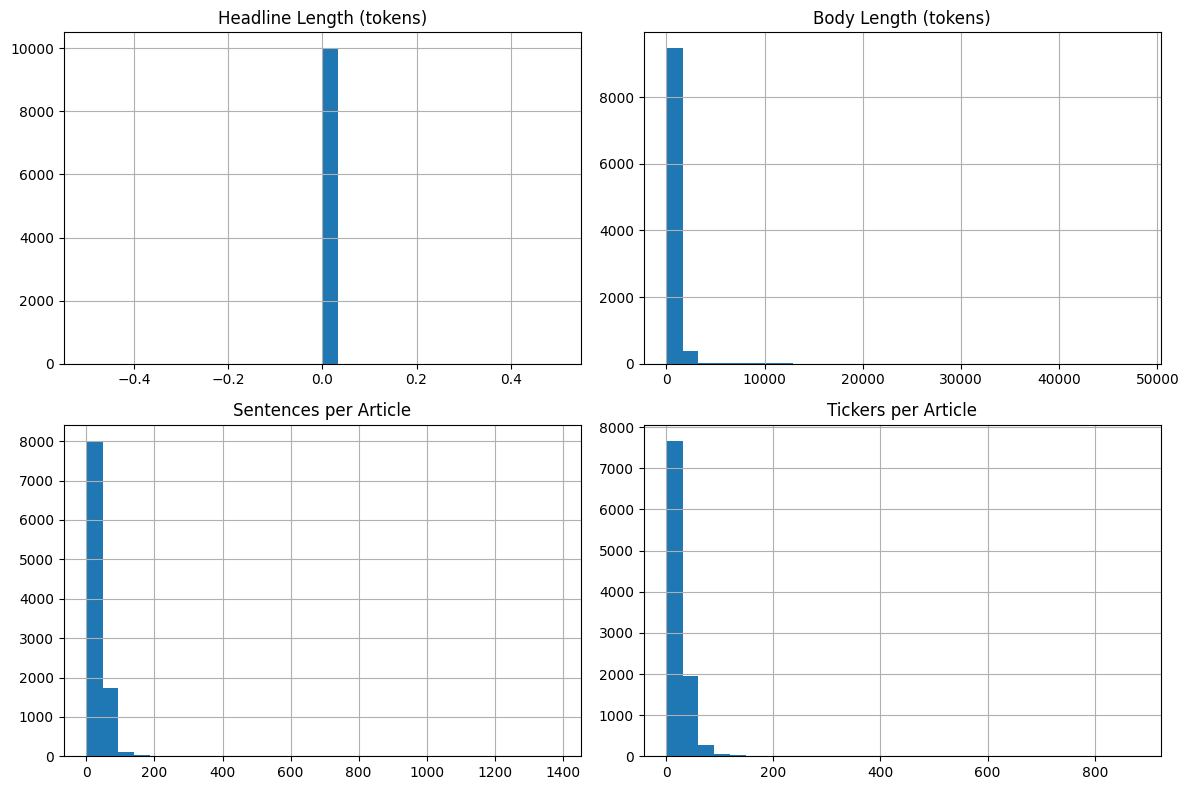

✔ Saved statistics to data/sampled/10k_article_stats.csv


In [10]:
import json
import re
from tqdm import tqdm
import pandas as pd
import spacy
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# (Re‐run NLTK & spaCy setup if needed)
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "lemmatizer"])

stats = []

# Open with utf-8 + ignore errors to avoid cp1255 decode issues
with open("../data/sampled/10k_sample.jsonl", "r", encoding="utf-8", errors="ignore") as fin:
    for line in tqdm(fin, total=SAMPLE_SIZE):
        art = json.loads(line)
        headline = art.get("headline_summary", "")
        body = art.get("body", "")

        # 1) Token counts
        headline_tokens = word_tokenize(headline)
        body_tokens = word_tokenize(body)

        # 2) Sentence counts
        full_text = (headline + " " + body).strip()
        sents = sent_tokenize(full_text)

        # 3) Simple ticker‐extraction
        doc = nlp(full_text)
        spacy_tickers = {ent.text for ent in doc.ents if ent.label_ in ("ORG", "PRODUCT")}
        regex_tickers = set(re.findall(r"\b[A-Z]{1,4}\b", full_text))
        tickers = spacy_tickers.union(regex_tickers)

        stats.append({
            "headline_len": len(headline_tokens),
            "body_len": len(body_tokens),
            "n_sentences": len(sents),
            "n_tickers": len(tickers),
        })

# Convert to DataFrame and inspect
df_stats = pd.DataFrame(stats)
print("Descriptive statistics:")
display(df_stats.describe())

# Plot histograms
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

df_stats["headline_len"].hist(bins=30, ax=axes[0,0])
axes[0,0].set_title("Headline Length (tokens)")

df_stats["body_len"].hist(bins=30, ax=axes[0,1])
axes[0,1].set_title("Body Length (tokens)")

df_stats["n_sentences"].hist(bins=30, ax=axes[1,0])
axes[1,0].set_title("Sentences per Article")

df_stats["n_tickers"].hist(bins=30, ax=axes[1,1])
axes[1,1].set_title("Tickers per Article")

plt.tight_layout()
plt.show()

# Save stats to CSV (specify encoding, though default is generally fine)
df_stats.to_csv("../data/sampled/10k_article_stats.csv", index=False, encoding="utf-8")
print("✔ Saved statistics to data/sampled/10k_article_stats.csv")


Plot Histograms

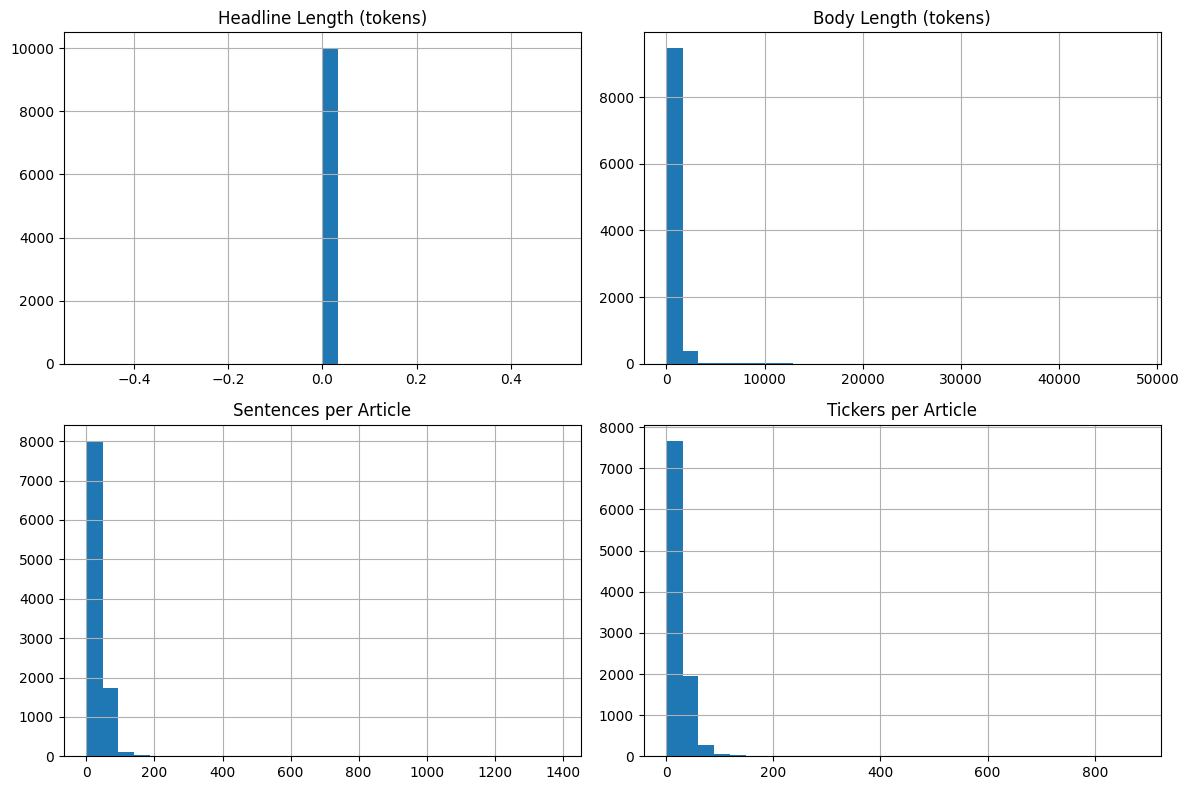

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

df_stats["headline_len"].hist(bins=30, ax=axes[0,0])
axes[0,0].set_title("Headline Length (tokens)")

df_stats["body_len"].hist(bins=30, ax=axes[0,1])
axes[0,1].set_title("Body Length (tokens)")

df_stats["n_sentences"].hist(bins=30, ax=axes[1,0])
axes[1,0].set_title("Sentences per Article")

df_stats["n_tickers"].hist(bins=30, ax=axes[1,1])
axes[1,1].set_title("Tickers per Article")

plt.tight_layout()
plt.show()


Save Stats to CSV

In [13]:
import os
os.makedirs("../data/sampled", exist_ok=True)
df_stats.to_csv("../data/sampled/10k_article_stats.csv", index=False)
print("✔ Saved statistics to data/sampled/10k_article_stats.csv")


✔ Saved statistics to data/sampled/10k_article_stats.csv


View a Few Rows

In [14]:
df_stats.head(10)


,headline_len,body_len,n_sentences,n_tickers
0,0,892,40,37
1,0,957,41,26
2,0,704,34,20
3,0,784,30,19
4,0,803,37,23
5,0,735,36,21
6,0,83,2,6
7,0,485,14,13
8,0,314,9,15
9,0,513,18,24
